In [1]:
import ROOT as r 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Welcome to JupyROOT 6.24/02


In [2]:
directory= "/Users/adit/Google Drive/Internship_ Research/Muon g-2/Data Filed/combined_forAdit_timealigned.root"
f = r.TFile(directory)

In [3]:
f.cd('LaserEvents')
t = f.Get('LaserEvents/tree')
df = pd.DataFrame(r.RDataFrame(t).AsNumpy())
c= r.TCanvas()

In [4]:
run = 25026
subRun = 2
fill = 178
calo = 20
xtal =14

In [6]:
print(df.describe())
print(df.nunique())
print(df.head())

       gpsTimeStamp  cccTimeStamp        runNum     subRunNum       fillNum  \
count  3.779552e+07  3.779552e+07  3.779552e+07  3.779552e+07  3.779552e+07   
mean   1.555790e+09  9.911910e+10  2.496101e+04  2.245266e+02  1.342963e+02   
std    2.544310e+05  5.867342e+10  8.201021e+01  1.350690e+02  7.734417e+01   
min    1.554982e+09  2.163583e+08  2.468500e+04  0.000000e+00  1.000000e+00   
25%    1.555664e+09  4.969637e+10  2.492800e+04  1.090000e+02  6.600000e+01   
50%    1.556000e+09  9.647675e+10  2.502600e+04  2.150000e+02  1.370000e+02   
75%    1.556003e+09  1.477690e+11  2.502600e+04  3.380000e+02  1.960000e+02   
max    1.556034e+09  2.220666e+11  2.503200e+04  4.930000e+02  3.770000e+02   

           bunchNum    fillType       caloNum       xtalNum      sipmTime  \
count  3.779552e+07  37795516.0  3.779552e+07  3.779552e+07  3.779552e+07   
mean   7.500986e+00         1.0  1.249642e+01  2.651775e+01  1.989889e+05   
std    4.609085e+00         0.0  6.923995e+00  1.557810e+

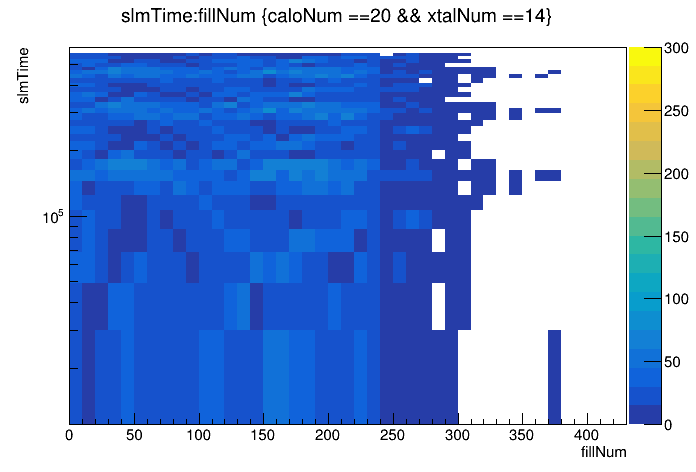

In [265]:
t.Draw('slmTime:fillNum', "caloNum =={} && xtalNum =={}".format(calo,xtal), 'colz')
c.Draw()

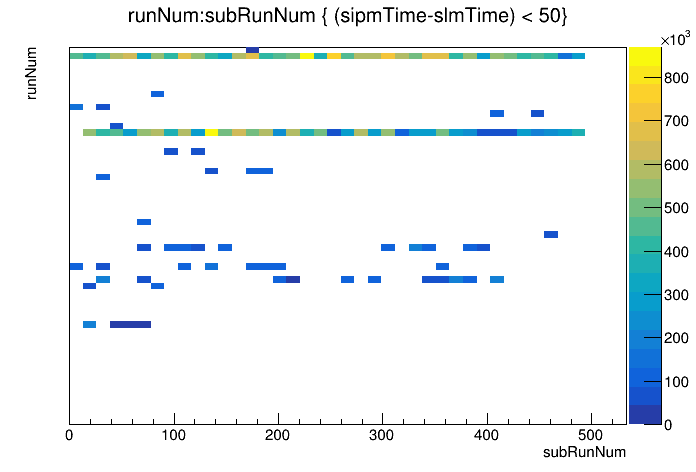

In [266]:
t.Draw('runNum:subRunNum',' (sipmTime-slmTime) < 50','colz')
c.Draw()

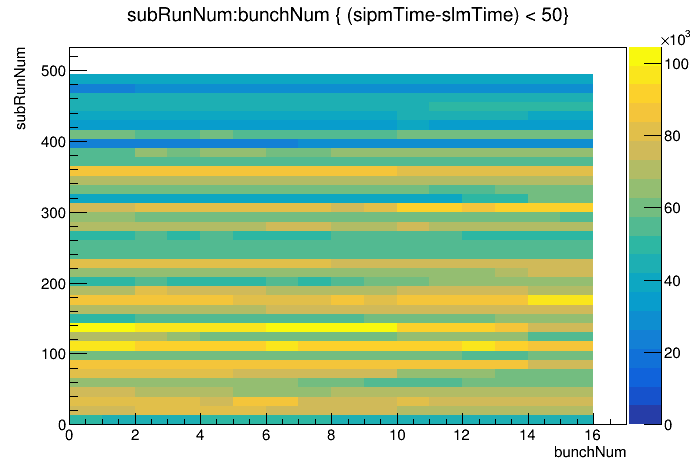

In [42]:
t.Draw('subRunNum:bunchNum',' (sipmTime-slmTime) < 50','colz')
c2.Draw()
#interesitng property, number of data points is consistent across a subRun i.e. no cuts within a bunch

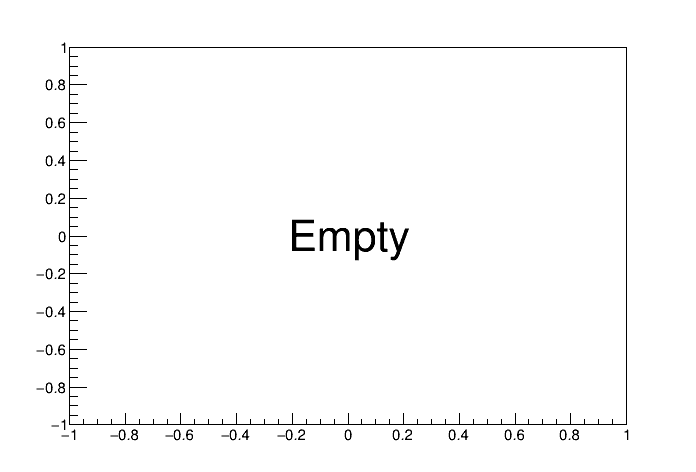

In [251]:
t.Draw('caloNum:xtalNum', "runNum =={} && subRunNum=={} && fillNum == {}".format(run,subRun,fill), 'colz')
c.SetLogy(0)
c.Draw()


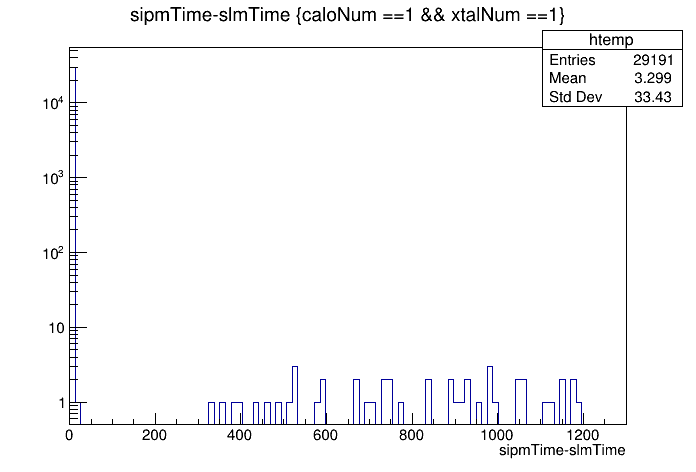

In [5]:
t.Draw('sipmTime-slmTime', "caloNum ==1 && xtalNum ==1")
c.SetLogy()
c.Draw()

In [6]:
df_filtered = df.loc[(df['sipmTime']-df['slmTime']) < 50]
df_noise = df.loc[(df['sipmTime']-df['slmTime']) > 50]
#evaluated this in a diff notebook, nothing significant, no commonalities, only 47 of 29k entries

In [36]:
#syncPulse = df_xtal.groupby(['runNum','subRunNum','fillNum']).idxmin()['slmTime'].reset_index()
#print(syncPulse['slmTime'])
#df_xtal.iloc[syncPulse['slmTime']]

0       20297336
1       20302516
2       20308721
3       20315196
4       20321671
          ...   
6348    29203900
6349    29209076
6350    29214252
6351    29220453
6352    29226923
Name: slmTime, Length: 6353, dtype: int64


In [27]:
df_xtal = df_filtered[(df_filtered['caloNum']==calo)& (df_filtered['xtalNum']==xtal)]
syncPulse = df_xtal[df_xtal['slmTime']< -10000][['runNum','subRunNum','fillNum', 'slmEnergy']]
laserPulse = df_xtal[df_xtal['slmTime']> -10000]

In [28]:
syncPulse.rename({'slmEnergy': 'syncEnergy'}, axis = 'columns',inplace=True )
laserPulse  = pd.merge(laserPulse,syncPulse, how = 'inner', on = ['runNum','subRunNum','fillNum'])
laserPulse['normalSlmEnergy'] = (laserPulse['slmEnergy']/laserPulse['syncEnergy'])

Warning in <TDirectoryFile::Append>: Replacing existing TH1: h_0 (Potential memory leak).


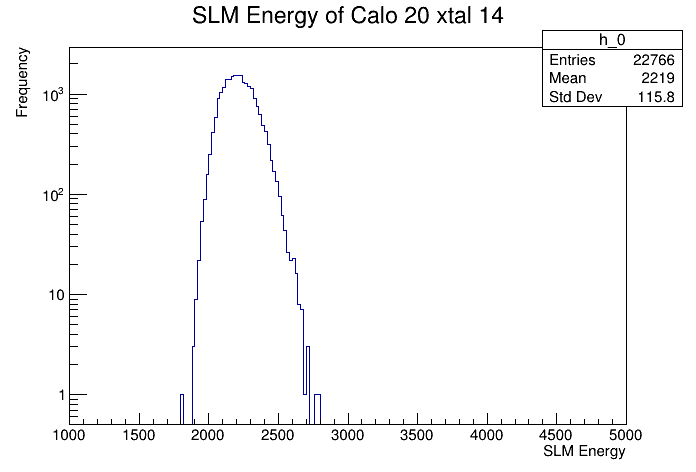

In [29]:
h0 = r.TH1D(f"h_{0}", "SLM Energy of Calo {} xtal {}; SLM Energy; Frequency".format(calo,xtal), 200, 1000, 5000)

for x in laserPulse['slmEnergy']:
    h0.Fill(x)

h0.Draw()
c.Draw()


Warning in <TDirectoryFile::Append>: Replacing existing TH1: h_1 (Potential memory leak).


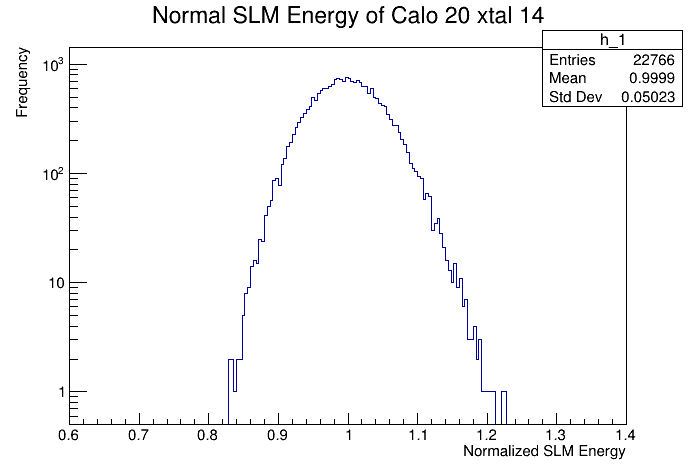

In [30]:
c.SetLogy()

h1 = r.TH1D(f"h_{1}", "Normal SLM Energy of Calo {} xtal {}; Normalized SLM Energy; Frequency".format(calo,xtal), 200, 0.6, 1.4)

for x in laserPulse['normalSlmEnergy']:
    h1.Fill(x)

h1.Draw()
c.Draw()

#see a spike at 1, probably because of a large proportion of sync Pulses

Warning in <TDirectoryFile::Append>: Replacing existing TH1: h_1 (Potential memory leak).


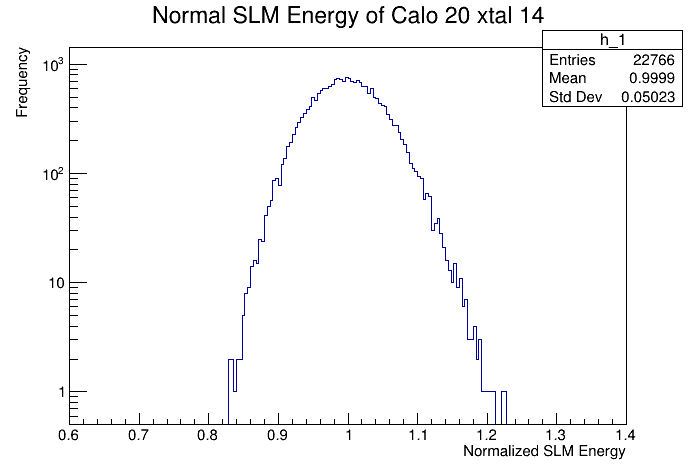

In [31]:
#looking at non sync pulses to see if they are major contributor

h1 = r.TH1D(f"h_{1}", "Normal SLM Energy of Calo {} xtal {}; Normalized SLM Energy; Frequency".format(calo,xtal), 200, 0.6, 1.4)

for x in laserPulse[laserPulse['normalSlmEnergy']!=1]['normalSlmEnergy']:
    h1.Fill(x)

h1.Draw()
c.Draw()

#corrected, fairly Gaussian distribution of laser pulses

Warning in <TDirectoryFile::Append>: Replacing existing TH1: h_2 (Potential memory leak).


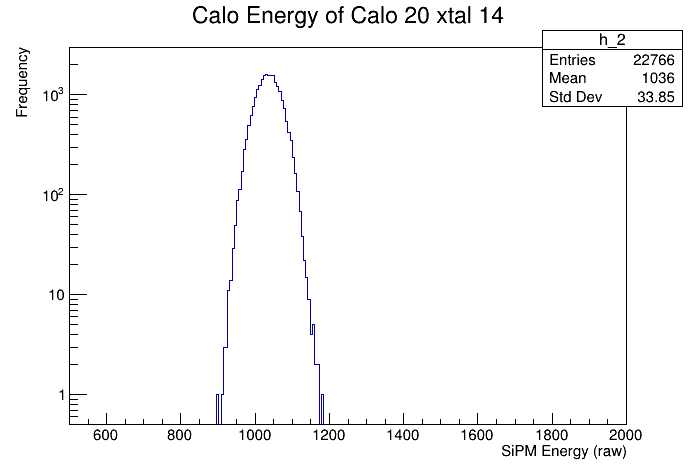

In [32]:
h2 = r.TH1D(f"h_{2}", "Calo Energy of Calo {} xtal {}; SiPM Energy (raw); Frequency".format(calo,xtal), 250, 500, 2000)

for x in laserPulse['sipmEnergy']:
    h2.Fill(x)

h2.Draw()
c.Draw()



Warning in <TDirectoryFile::Append>: Replacing existing TH1: h_3 (Potential memory leak).


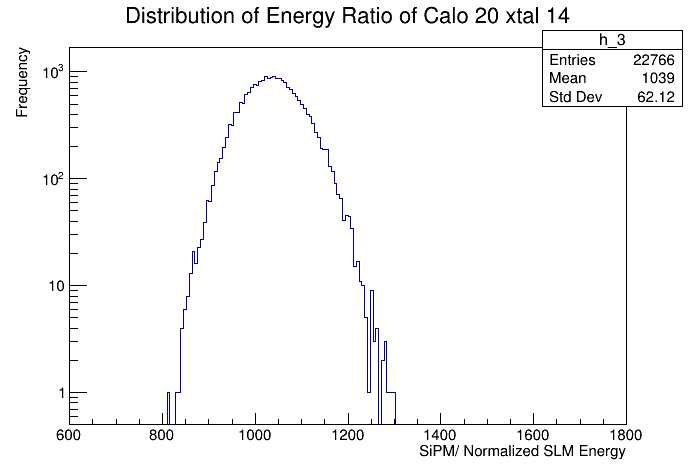

In [34]:
h3 = r.TH1D(f"h_{3}", "Distribution of Energy Ratio of Calo {} xtal {}; SiPM/ Normalized SLM Energy; Frequency".format(calo,xtal), 200, 600, 1800)

for x in laserPulse['sipmEnergy']/laserPulse['normalSlmEnergy']:
    h3.Fill(x)

h3.Draw()
c.Draw()

mean_temp = h3.GetMean()

Warning in <TDirectoryFile::Append>: Replacing existing TH1: h_4 (Potential memory leak).


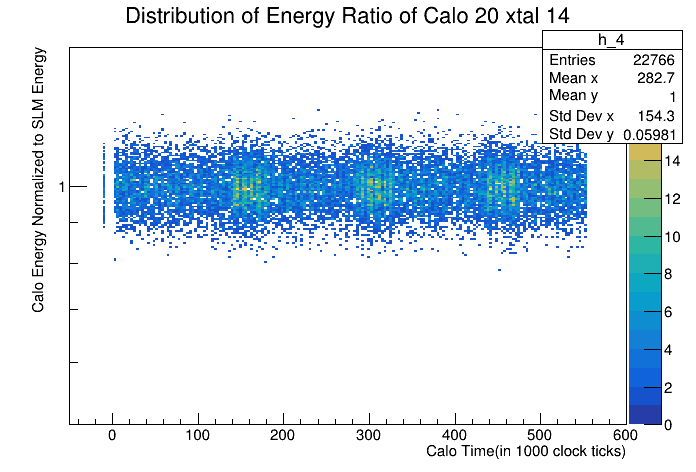

In [35]:
h4 = r.TH2D(f"h_{4}", "Distribution of Energy Ratio of Calo {} xtal {}; Calo Time(in 1000 clock ticks); Calo Energy Normalized to SLM Energy".format(calo,xtal),
            200, -50, 600,
            200,0.5,1.5)

for (x,y) in zip(laserPulse['sipmTime'], laserPulse['sipmEnergy']/laserPulse['normalSlmEnergy']/mean_temp):
    h4.Fill(x/1000,y)

h4.Draw('colz')
c.Draw()



Slope: -2.089342053159197e-09
Standard Deviation: 0.00082959424295297


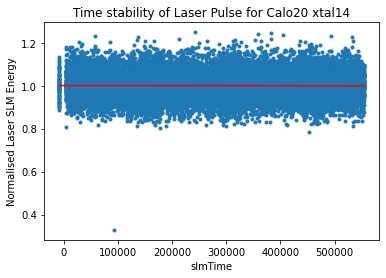

In [39]:
fig,ax = plt.subplots()
ax.plot(laserPulse['sipmTime'],laserPulse['sipmEnergy']/laserPulse['normalSlmEnergy']/mean_temp,".")
ax.set_title("Time stability of Laser Pulse for Calo{} xtal{}".format(calo,xtal))
ax.set_xlabel("slmTime")
ax.set_ylabel("Normalised Laser SLM Energy")
# fit a curve (linear for now) through the stability of time 

def func(x,m,b):
    return m*x + b 

initial_guess = [1.2, 0.03]
pars, pcov = curve_fit(func, laserPulse['sipmTime'], laserPulse['sipmEnergy']/laserPulse['normalSlmEnergy']/mean_temp, p0=initial_guess)
xfit = np.linspace(np.amin(laserPulse['sipmTime']),np.amax(laserPulse['sipmTime']))
yfit = func(xfit, pars[0], pars[1])
plt.plot(xfit,yfit,'r-',label=f"Linear Fit\nm={pars[0]:.2f}\nb={pars[1]:.2f}")

print("Slope: {}".format(pars[0]))
print("Standard Deviation: {}".format(np.sqrt(pcov[1,1])))

In [40]:
#automation of the whole process to find out errors and time stabilities of all calo

timeGrowth = np.zeros((24,54))
timeStd = np.zeros((24,54))

for calo in pd.unique(df['caloNum'])[:14]:
    for xtal in  pd.unique(df['xtalNum']):

        df_xtal = df_filtered[(df_filtered['caloNum']==calo)& (df_filtered['xtalNum']==xtal)]
        syncPulse = df_xtal[df_xtal['slmTime']< -10000][['runNum','subRunNum','fillNum', 'slmEnergy']]
        laserPulse = df_xtal[df_xtal['slmTime']> -10000]
        
        syncPulse.rename({'slmEnergy': 'syncEnergy'}, axis = 'columns',inplace=True )
        laserPulse  = pd.merge(laserPulse,syncPulse, how = 'inner', on = ['runNum','subRunNum','fillNum'])
        laserPulse['normalSlmEnergy'] = (laserPulse['slmEnergy']/laserPulse['syncEnergy'])
        
        mean = laserPulse['sipmEnergy']/laserPulse['normalSlmEnergy'].mean()
        
        def func(x,m,b):
            return m*x + b 

        initial_guess = [1.2, 0.03]
        pars, pcov = curve_fit(func, laserPulse['sipmTime'], laserPulse['sipmEnergy']/laserPulse['normalSlmEnergy']/mean, p0=initial_guess)

        timeGrowth[calo-1][xtal] = pars[0]
        timeStd[calo-1][xtal] = np.sqrt(pcov[1,1])

ValueError: `ydata` must not be empty!

In [42]:
for calo in pd.unique(df['caloNum'])[14:]:
    for xtal in  pd.unique(df['xtalNum']):

        df_xtal = df_filtered[(df_filtered['caloNum']==calo)& (df_filtered['xtalNum']==xtal)]
        syncPulse = df_xtal[df_xtal['slmTime']< -10000][['runNum','subRunNum','fillNum', 'slmEnergy']]
        laserPulse = df_xtal[df_xtal['slmTime']> -10000]
        
        syncPulse.rename({'slmEnergy': 'syncEnergy'}, axis = 'columns',inplace=True )
        laserPulse  = pd.merge(laserPulse,syncPulse, how = 'inner', on = ['runNum','subRunNum','fillNum'])
        laserPulse['normalSlmEnergy'] = (laserPulse['slmEnergy']/laserPulse['syncEnergy'])
        
        mean = laserPulse['sipmEnergy']/laserPulse['normalSlmEnergy'].mean()
        
        def func(x,m,b):
            return m*x + b 

        initial_guess = [1.2, 0.03]
        pars, pcov = curve_fit(func, laserPulse['sipmTime'], laserPulse['sipmEnergy']/laserPulse['normalSlmEnergy']/mean, p0=initial_guess)

        timeGrowth[calo-1][xtal] = pars[0]
        timeStd[calo-1][xtal] = np.sqrt(pcov[1,1])

Rate of Change of Eneergy Ratio scaled by 100000000000


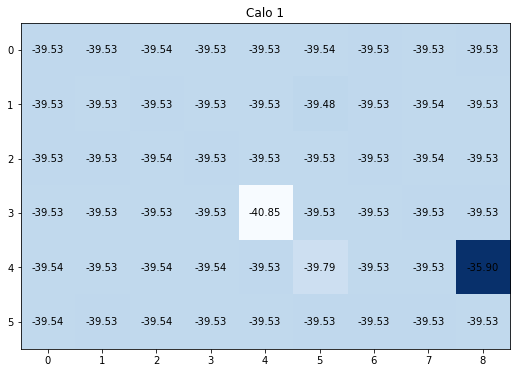

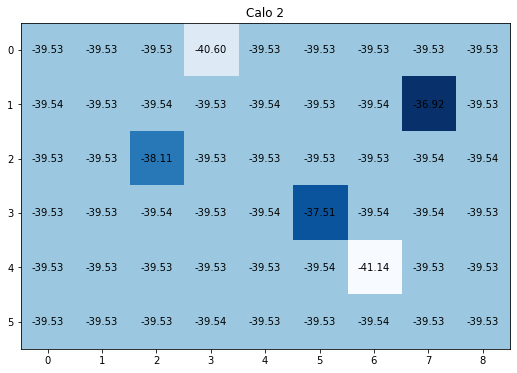

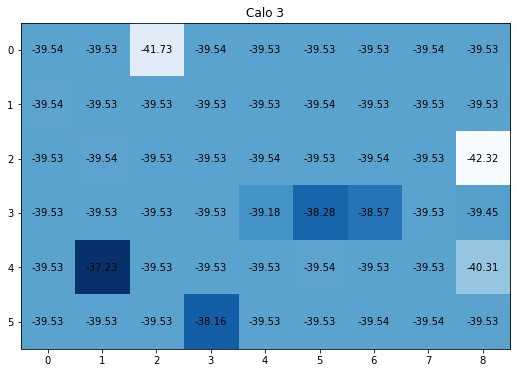

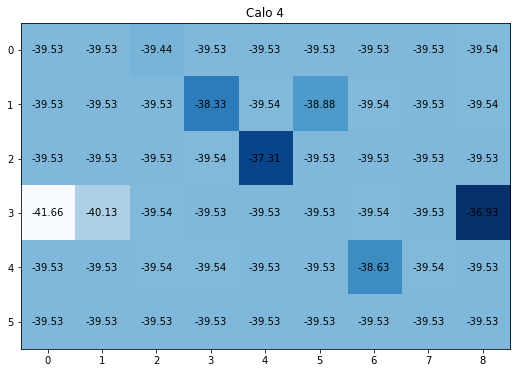

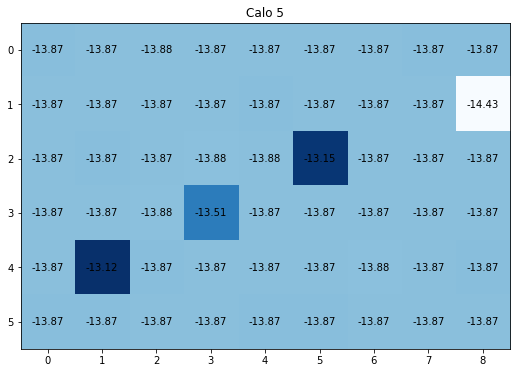

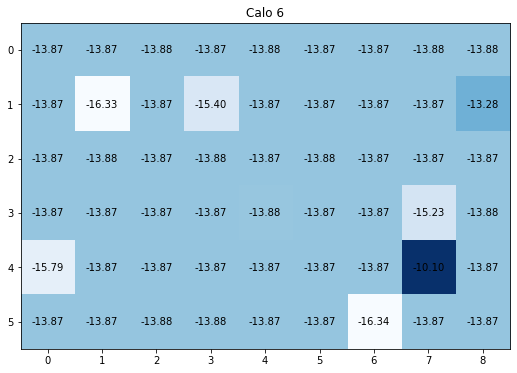

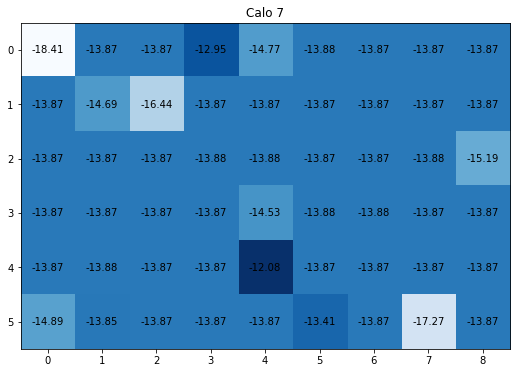

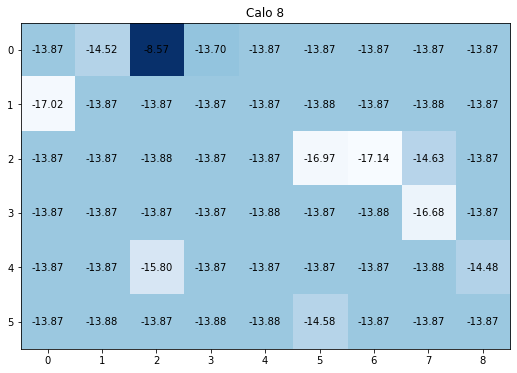

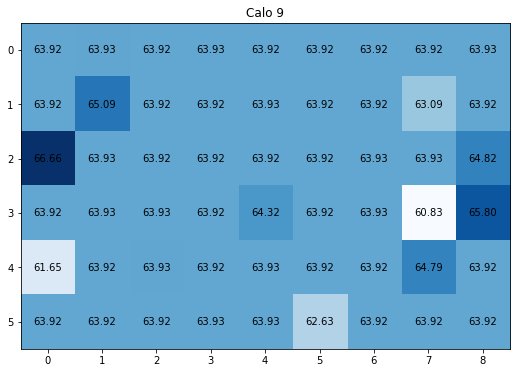

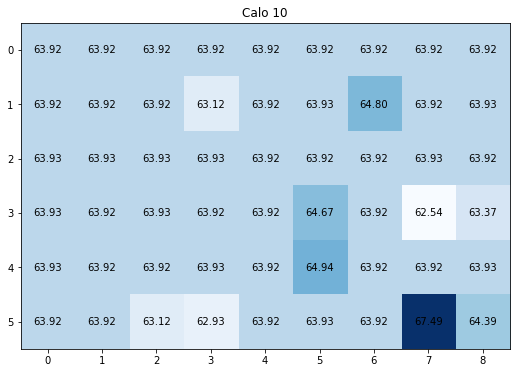

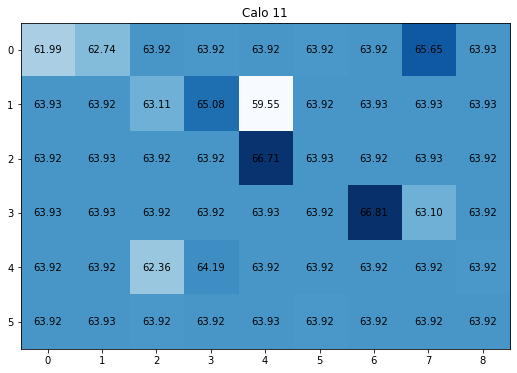

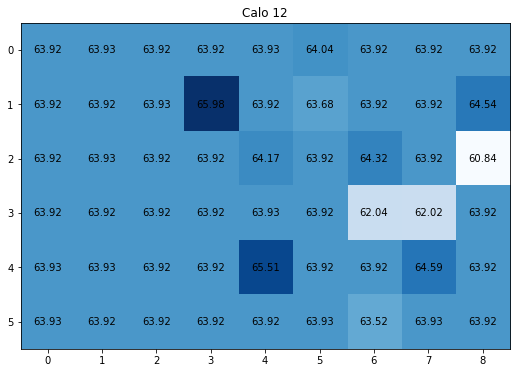

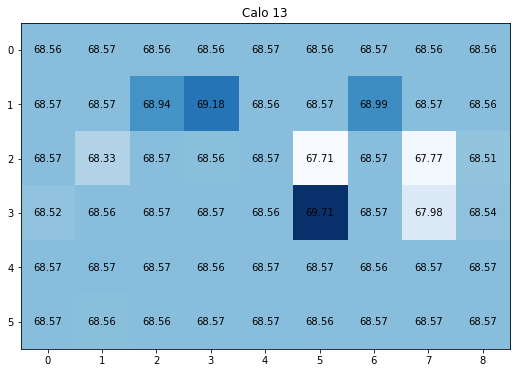

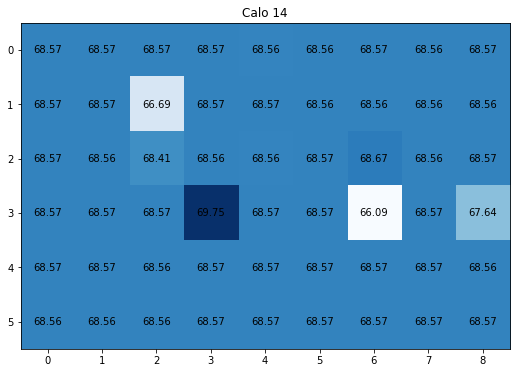

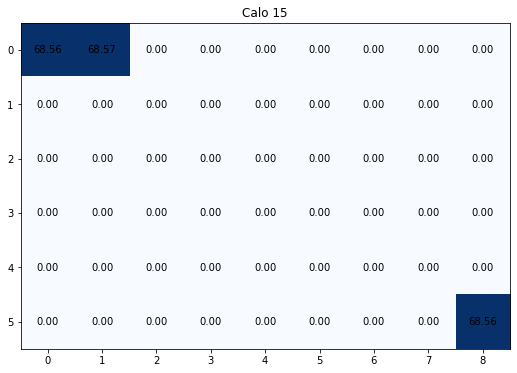

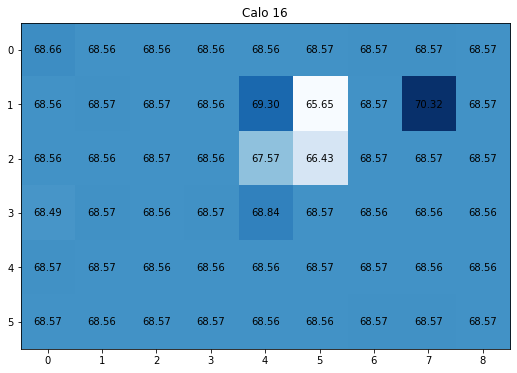

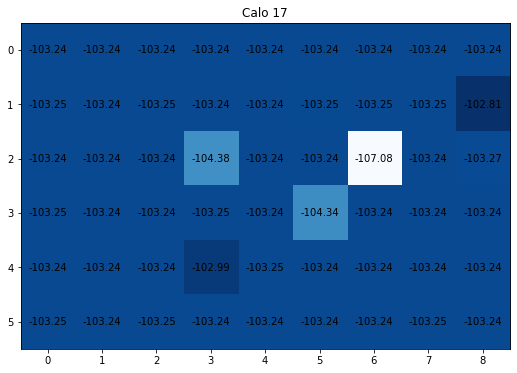

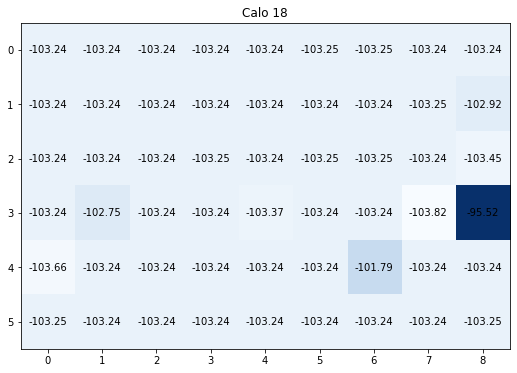

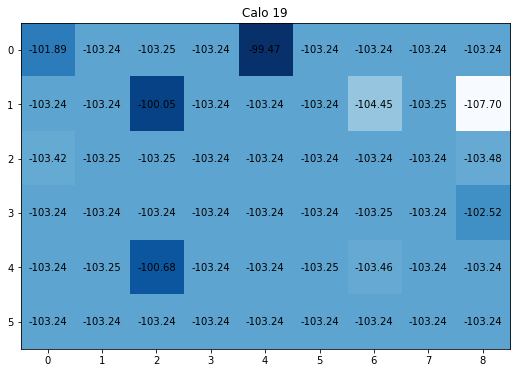

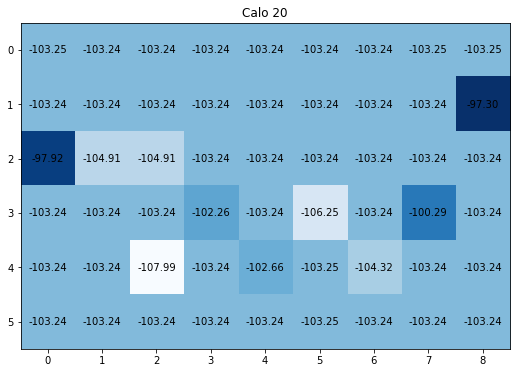

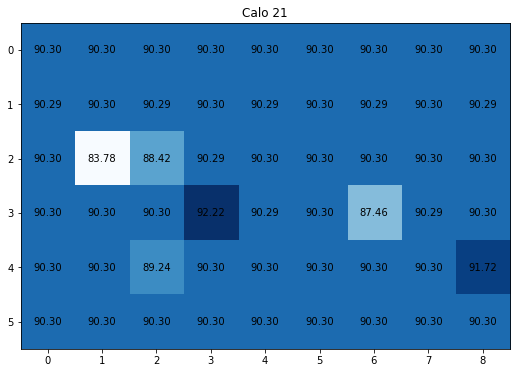

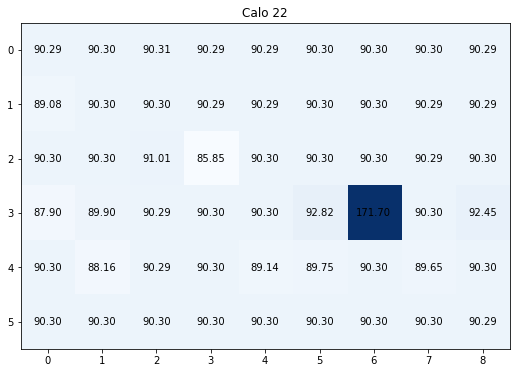

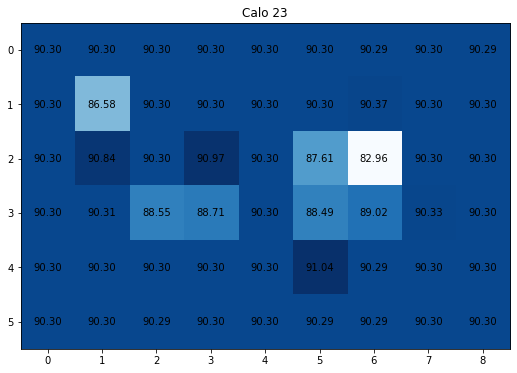

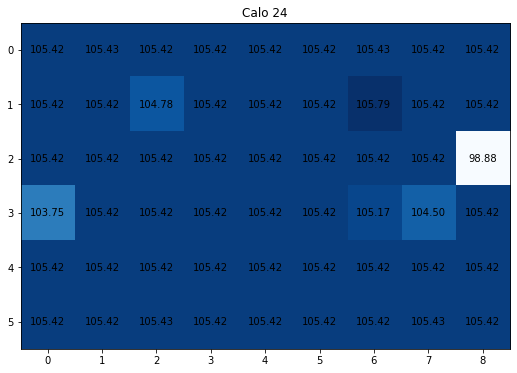

In [45]:
plt.rcParams["figure.figsize"] = (12,6) 
scale1 = (10**11)

print("Rate of Change of Eneergy Ratio scaled by {}".format(scale1))

for calo in pd.unique(df['caloNum']):
    fig,ax = plt.subplots()
    im = ax.imshow(timeGrowth[calo-1].reshape(6,9)*scale1,cmap=plt.cm.Blues)
    for i in range(6):
        for j in range(9):
            text = ax.text(j, i,"{0:.2f}".format(timeGrowth[calo-1].reshape(6,9)[i, j]*scale1),
                           ha="center", va="center", color="black")        
    plt.title('Calo {}'.format(calo))
    plt.show()
   

Error in Rate of Change of Energy Ratio scaled by 100000


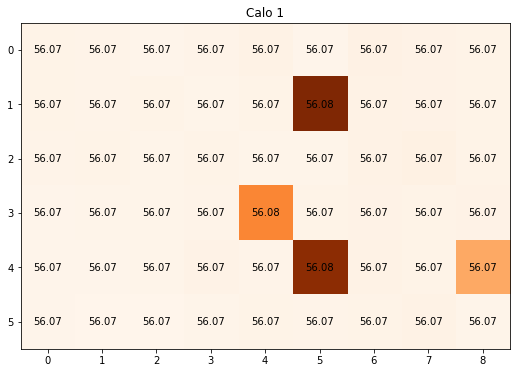

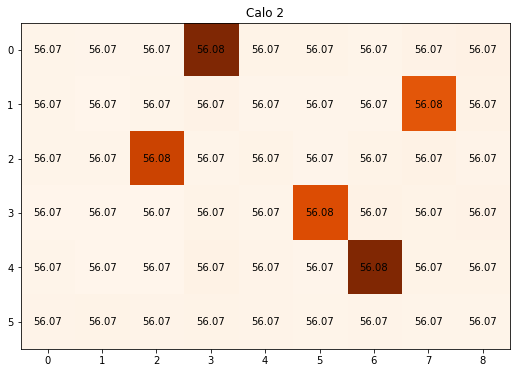

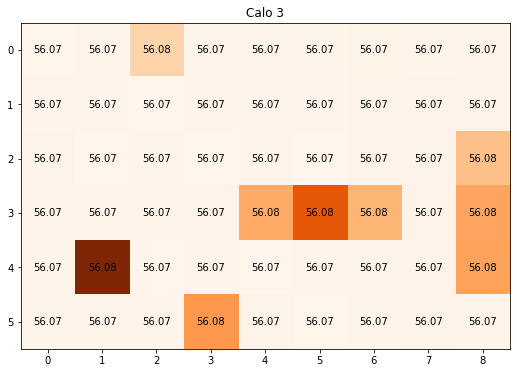

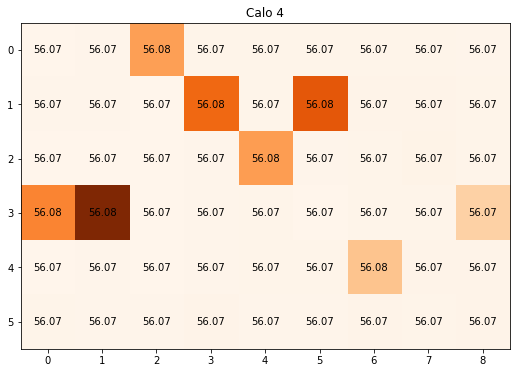

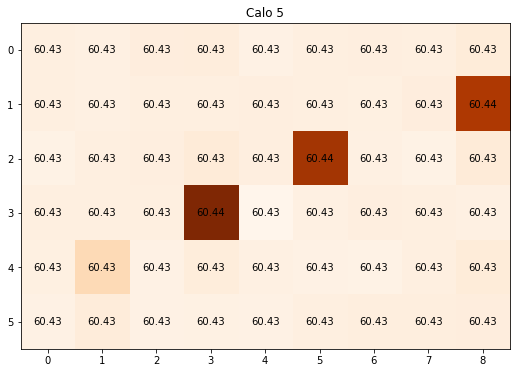

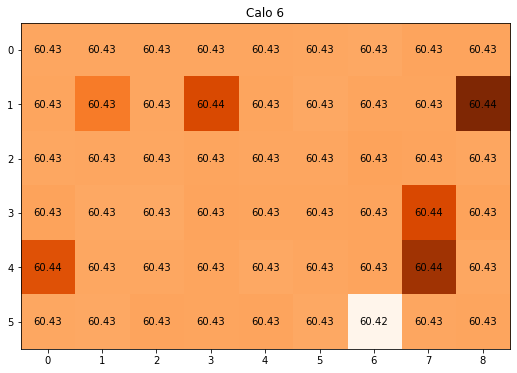

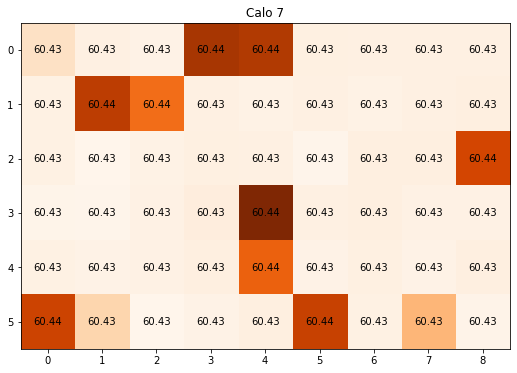

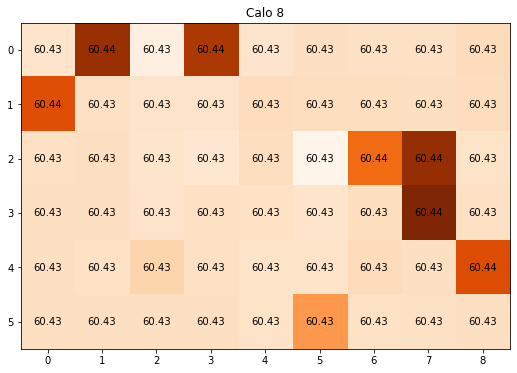

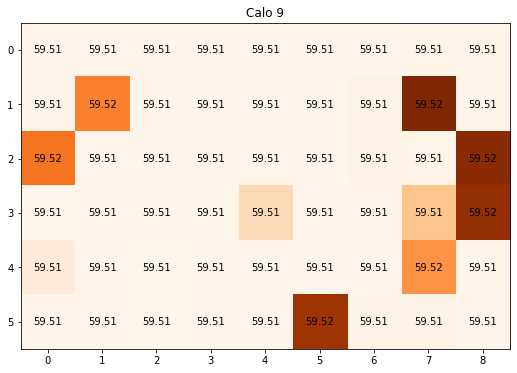

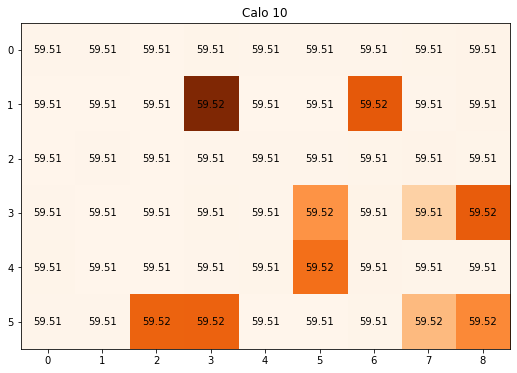

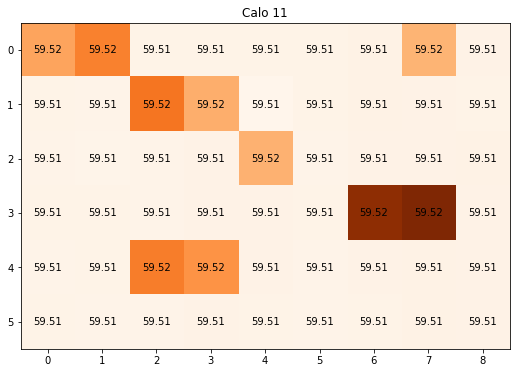

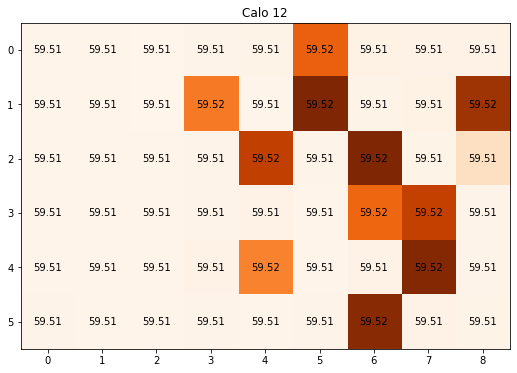

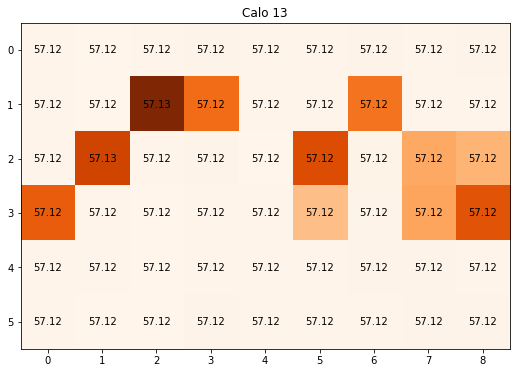

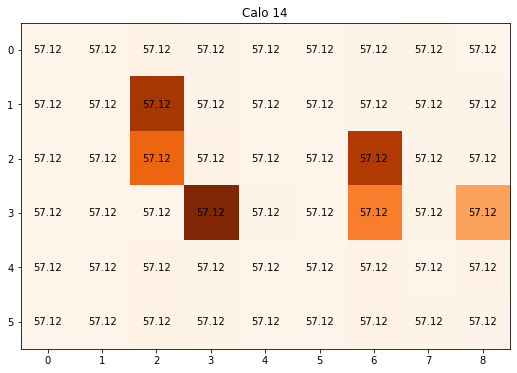

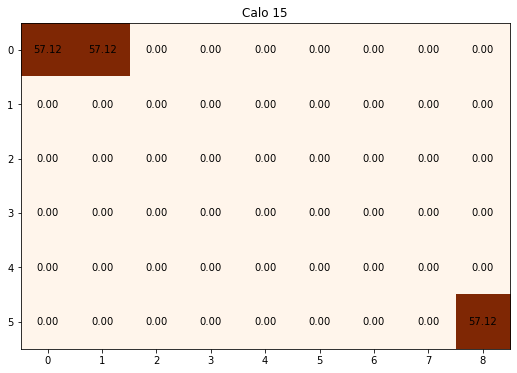

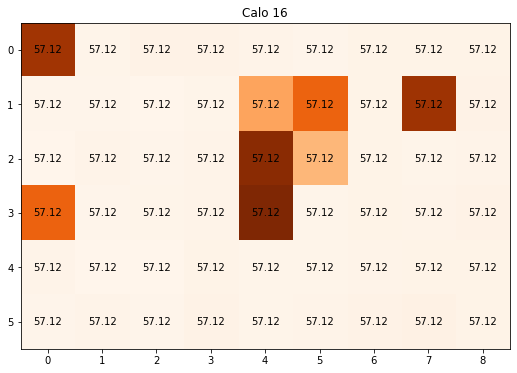

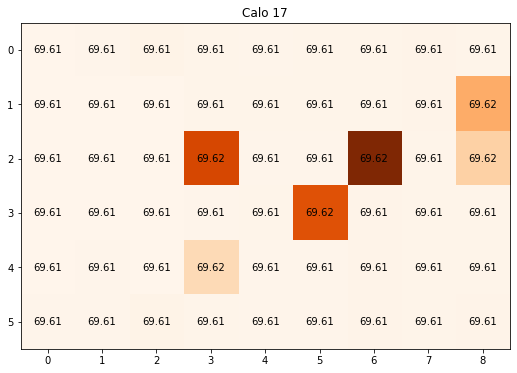

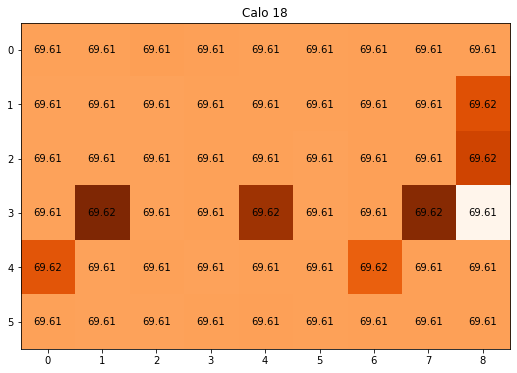

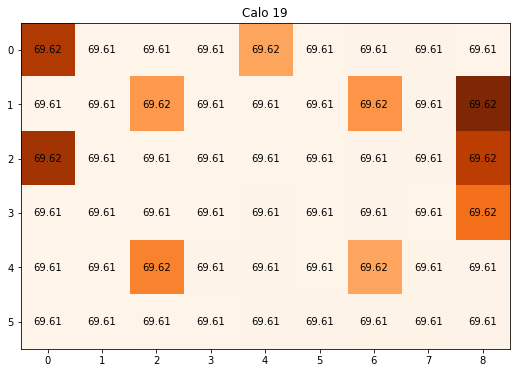

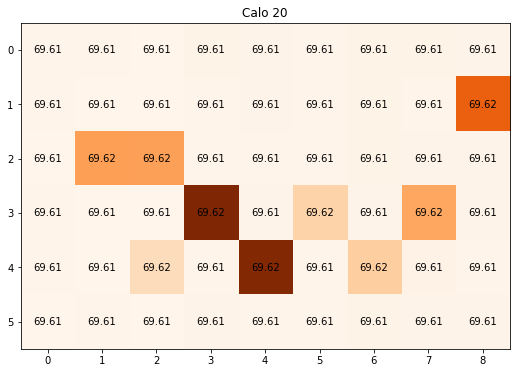

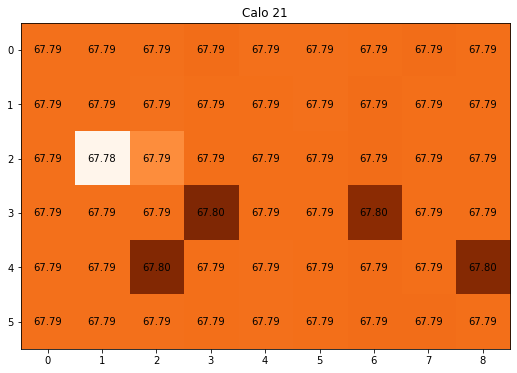

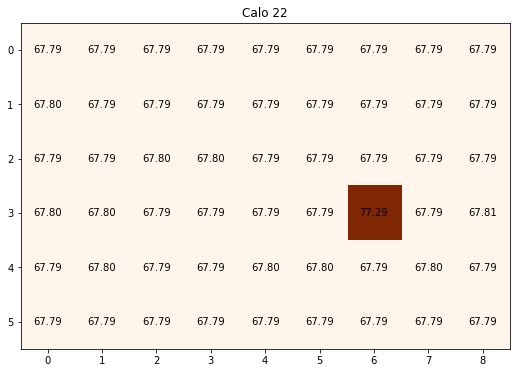

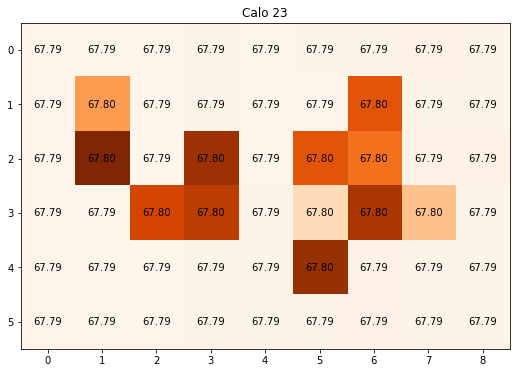

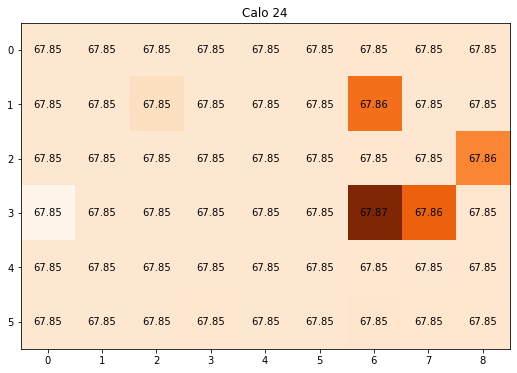

In [46]:
plt.rcParams["figure.figsize"] = (12,6) 

scale2 = (10**5)

print("Error in Rate of Change of Energy Ratio scaled by {}".format(scale2))

for calo in pd.unique(df['caloNum']):
    fig,ax = plt.subplots()
    im = ax.imshow(timeStd[calo-1].reshape(6,9)*scale2,cmap=plt.cm.Oranges)
    for i in range(6):
        for j in range(9):
            text = ax.text(j, i,"{0:.2f}".format(timeStd[calo-1].reshape(6,9)[i, j]*scale2),
                           ha="center", va="center", color="black")        
    plt.title('Calo {}'.format(calo))
    plt.show()

In [47]:
caloAvgGrowth = np.zeros(24)
for calo in pd.unique(df['caloNum']):
    caloAvgGrowth[calo-1] = timeGrowth[calo-1].mean()
    
caloAvgError = np.zeros(24)
for calo in pd.unique(df['caloNum']):
    caloAvgError[calo-1] = timeStd[calo-1].max()

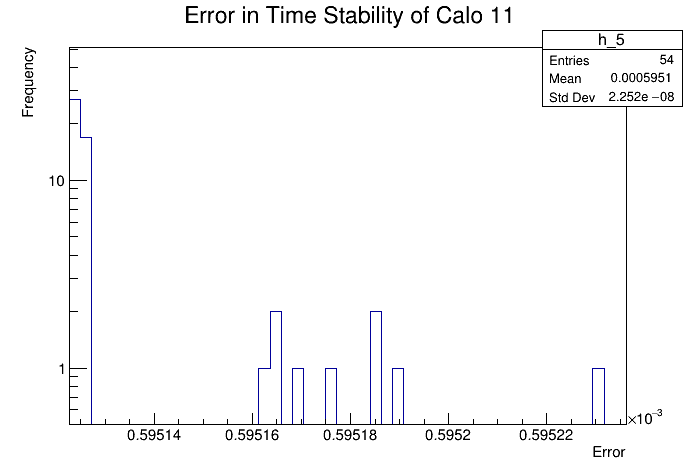

In [48]:
calo = 11
h5 = r.TH1D(f"h_{5}", "Error in Time Stability of Calo {}; Error; Frequency".format(calo), 50, timeStd[calo-1].min(), timeStd[calo-1].max()*1)

for x in timeStd[calo-1]:
    h5.Fill(x)

h5.Draw()
c.Draw()

#semi  

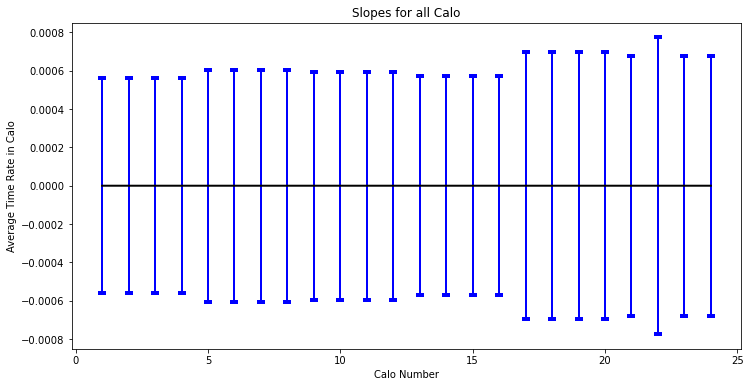

In [49]:
fig, ax = plt.subplots()

ax.errorbar(pd.unique(df['caloNum']), caloAvgGrowth, yerr= caloAvgError, lw = 2,capsize = 4, capthick = 4, ecolor = "blue", color = 'black')
plt.xlabel("Calo Number")
plt.ylabel("Average Time Rate in Calo")
plt.title("Slopes for all Calo")
plt.show()
